<a href="https://colab.research.google.com/github/pchanial/python-for-data-scientists/blob/master/Course_Numpy_JAX_APC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numpy & JAX



## Objectives of the course:
- Understand why Numpy is faster than Vanilla Python
- Understand why JAX is faster than Numpy
- Numpy concepts no more applicable to JAX
- Numpy concepts still applicable to JAX


In [89]:
# imports necessary for the course
import timeit
from typing import Any, Callable, Sequence
import jax
import jax.numpy as jnp
import jaxlib
import numpy as np
import polars as pl

print('Devices:', jax.devices())
import time


# helpers
def pointer(x: np.ndarray) -> int:
  """Returns the memory address of the first array element."""
  return x.__array_interface__['data'][0]


def bench_one(func: Callable[[], Any]) -> float:
    """Returns execution time in s."""
    repeat = 7
    timer = timeit.Timer(func)
    number, _ = timer.autorange()
    runs = np.array([_ / number for _ in timer.repeat(repeat=repeat, number=number)])
    runs_ms = runs * 1000
    print(f'{np.mean(runs_ms):.3f} ms ± {np.std(runs_ms) * 1000:.2f} µs (mean ± std. dev. of {repeat} runs, {number} loops each)')
    return np.mean(runs)


def bench(func: Callable, values: Sequence[Any], *, setup: Callable | None = None) -> list[float]:
    elapsed_times = []
    for value in values:
        if setup is not None:
            args = setup(value)
        else:
            args = (value,)
        if isinstance(func, jaxlib.xla_extension.PjitFunction):
            benchmarked_func = lambda: func(*args).block_until_ready()
        else:
            benchmarked_func = lambda: func(*args)
        elapsed_times.append(bench_one(benchmarked_func))
    return elapsed_times


def bench_many(funcs: Sequence[Callable], values: Sequence[Any], *, setups: Sequence[Callable], labels: Sequence[str]) -> None:
    results = pl.DataFrame({'values': values})
    for func, setup, label in zip(funcs, setups, labels):
        run_times = bench(func, values, setup=setup)
        results = results.with_columns(pl.Series(label, run_times).alias(label))
        mp.loglog(values, run_times, marker='o', label=label)
    mp.ylabel('Elapsed time [s]')
    mp.legend()
    return results

Devices: [CpuDevice(id=0)]


0.006 ms ± 1.36 µs (mean ± std. dev. of 7 runs, 100000 loops each)
0.004 ms ± 0.24 µs (mean ± std. dev. of 7 runs, 50000 loops each)
0.005 ms ± 0.10 µs (mean ± std. dev. of 7 runs, 50000 loops each)
0.006 ms ± 0.19 µs (mean ± std. dev. of 7 runs, 50000 loops each)
0.011 ms ± 3.02 µs (mean ± std. dev. of 7 runs, 50000 loops each)
0.016 ms ± 3.56 µs (mean ± std. dev. of 7 runs, 10000 loops each)
0.024 ms ± 0.47 µs (mean ± std. dev. of 7 runs, 10000 loops each)
0.044 ms ± 1.25 µs (mean ± std. dev. of 7 runs, 5000 loops each)
0.086 ms ± 1.08 µs (mean ± std. dev. of 7 runs, 5000 loops each)
0.251 ms ± 55.30 µs (mean ± std. dev. of 7 runs, 2000 loops each)
0.326 ms ± 6.99 µs (mean ± std. dev. of 7 runs, 1000 loops each)
0.009 ms ± 0.20 µs (mean ± std. dev. of 7 runs, 50000 loops each)
0.010 ms ± 2.10 µs (mean ± std. dev. of 7 runs, 50000 loops each)
0.012 ms ± 2.74 µs (mean ± std. dev. of 7 runs, 20000 loops each)
0.010 ms ± 0.24 µs (mean ± std. dev. of 7 runs, 20000 loops each)
0.011 ms ± 0

AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

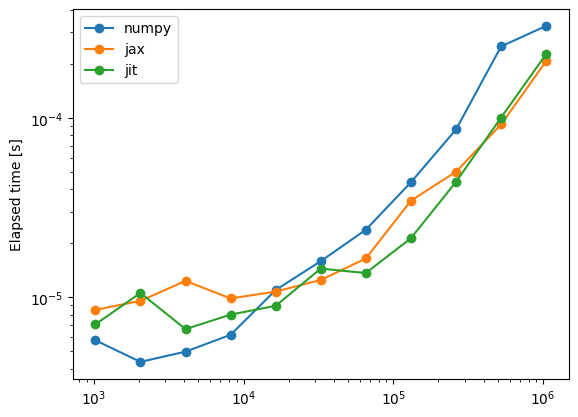

In [91]:
values = [2**n for n in range(10, 21)]

setup_numpy = lambda n: (np.arange(n, dtype=np.float32),)
setup_jax = lambda n: (jnp.arange(n, dtype=np.float32),)
results = bench_many(
    [np.sum, jnp.sum, jax.jit(jnp.sum)],
    values,
    setups=[setup_numpy, setup_jax, setup_jax],
    labels=['numpy', 'jax', 'jit'],
)
mp.title('sum(x)')

0.004 ms ± 1.09 µs (mean ± std. dev. of 7 runs, 100000 loops each)
0.011 ms ± 1.61 µs (mean ± std. dev. of 7 runs, 20000 loops each)
0.054 ms ± 2.94 µs (mean ± std. dev. of 7 runs, 5000 loops each)
0.864 ms ± 65.03 µs (mean ± std. dev. of 7 runs, 500 loops each)
26.171 ms ± 5478.23 µs (mean ± std. dev. of 7 runs, 10 loops each)
0.025 ms ± 4.56 µs (mean ± std. dev. of 7 runs, 20000 loops each)
0.021 ms ± 0.97 µs (mean ± std. dev. of 7 runs, 10000 loops each)
0.083 ms ± 2.59 µs (mean ± std. dev. of 7 runs, 5000 loops each)
5.041 ms ± 162.02 µs (mean ± std. dev. of 7 runs, 50 loops each)
59.738 ms ± 13551.97 µs (mean ± std. dev. of 7 runs, 5 loops each)
0.012 ms ± 0.23 µs (mean ± std. dev. of 7 runs, 20000 loops each)
0.009 ms ± 0.15 µs (mean ± std. dev. of 7 runs, 50000 loops each)
0.042 ms ± 1.55 µs (mean ± std. dev. of 7 runs, 5000 loops each)
0.460 ms ± 24.16 µs (mean ± std. dev. of 7 runs, 500 loops each)
23.419 ms ± 815.76 µs (mean ± std. dev. of 7 runs, 10 loops each)


Text(0.5, 1.0, '2x + y')

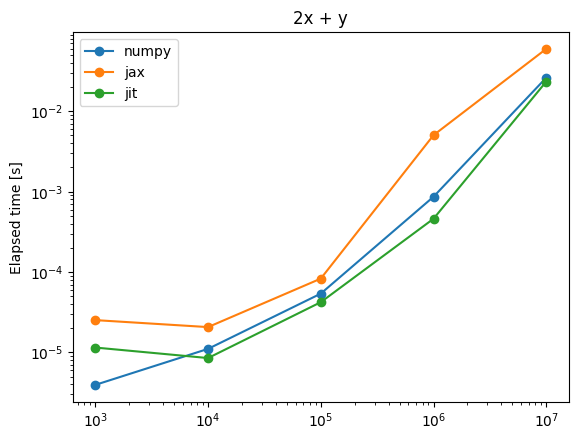

In [85]:
values = [10**n for n in range(3, 8)]

setup_numpy = lambda n: (np.arange(n, dtype=np.float32), np.arange(n, dtype=np.float32))
setup_jax = lambda n: (jnp.arange(n, dtype=np.float32), jnp.arange(n, dtype=np.float32))
results = bench_many(
    [lambda x, y: 2 * x + y, lambda x, y: 2 * x + y, jax.jit(lambda x, y: 2 * x + y)],
    values,
    setups=[setup_numpy, setup_jax, setup_jax],
    names=['numpy', 'jax', 'jit'],
)
mp.titled('2x + y')

## Why is Numpy faster than Vanilla Python

- Vanilla Python memory layout

![list of list](https://raw.githubusercontent.com/pchanial/python-for-data-scientists/gh-pages/source/layout_listoflist.png)

- Numpy memory layout

![ndarray](https://raw.githubusercontent.com/pchanial/python-for-data-scientists/gh-pages/source/layout_2darray.png)



## Why is JAX faster than Numpy



## Numpy concepts no more applicable to JAX
- inplace operations
- promotion rules
- np.random (use `jax.random`)


## Numpy concepts still applicable to JAX

- indexing
- broadcasting
- ufunc methods



### Indexing

### Broadcasting
Broadcasting allows operations (such as addition, multiplication etc.) which are normally element-wise to be carried on arrays of different shapes. It is a virtual replication of the arrays along the missing dimensions. It can be seen as a generalization of operations involving an array and a scalar.

- the addition of a scalar on an matrix can be seen as the addition of a matrix with identical elements (and same dimensions).

![broadcast scalar](https://raw.githubusercontent.com/pchanial/python-for-data-scientists/gh-pages/source/broadcast_scalar.png)

- the addition of a row on a matrix will be seen as the addition of a matrix with replicated rows (the number of columns must match).

![broadcast column](https://raw.githubusercontent.com/pchanial/python-for-data-scientists/gh-pages/source/broadcast_column.png)

- conversely the addition of a column on a matrix will be seen as the addition of a matrix with replicated columns (the number of rows must match)

![broadcast row](https://raw.githubusercontent.com/pchanial/python-for-data-scientists/gh-pages/source/broadcast_row.png)

- What if the rank of the arrays is greater than 2? There is no restriction on the rank: any dimension of length 1 is broadcastable and is virtually replicated to match the other array’s dimension length. The two arrays may have different broadcastable dimensions. If this happens, the result of the operation will have more elements than any of the operands.

- Can it work on arrays of different ranks? Sure! Dimensions of length 1 are prepended (added on the left of the array shape) until the two arrays have the same rank. As a consequence, the following operation is possible:

```python
np.zeros((5, 9)) + np.ones(9)
```

but not this one, since the righmost dimensions are different:

```python
np.zeros((5, 9)) + np.ones(5)
# ValueError: operands could not be broadcast together with shapes (5,9) (5)
```

So for columns, an additional dimension must be specified and added on the right:

```python
np.zeros((5, 9)) + np.ones(5)[:, None]
```

Can it work on more than two arrays? Yes again! But you have to find an element-wise operation with more than two operands...

Since the replication is virtual, no memory is wasted. Broadcasting is fast. Use it wherever possible, just keep an eye on the size of the broadcast result to make sure that it does not become too large.



In [ ]:
np.broadcast_shapes((3, 1, 4), (3, 4))

In [ ]:
a1 = np.ones((4, 1))
a2 = np.ones((2, 1, 3))
a1_broadcast, a2_broadcast = np.broadcast_arrays(a1, a2)
print('broadcast shapes:', a1_broadcast.shape, a2_broadcast.shape)
print('same memory layout:', pointer(a1) == pointer(a1_broadcast))
print(f'{a1.strides=}', f'{a1_broadcast.strides=}')

**Exercise 1**: Can the arrays of the following shapes be broadcast together? If yes, what would be the shape of the result?

    (7, 1) and (7, 4)
    (7,) and (4, 7)
    (3, 3) and (2, 3)**texte en gras**
    (1, 1, 1, 8) and (1, 9, 1)
    (4, 1, 9) and (3, 1)

**Exercice 2**: Remove the for loops in this code by using broadcasting and measure the improvement in execution time.


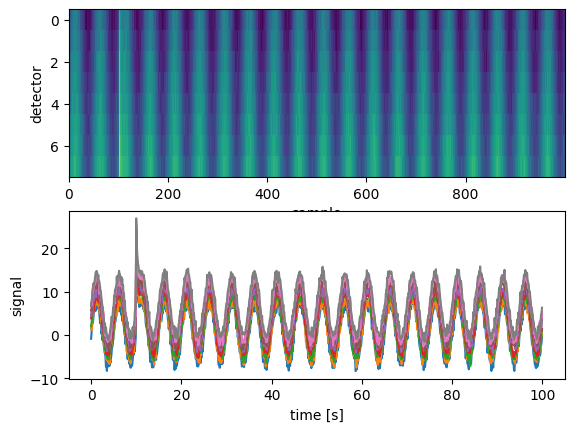

In [2]:
import matplotlib.pyplot as mp
import numpy as np

NDETECTOR = 8
NSAMPLE = 1000
SAMPLING_PERIOD = 0.1
GLITCH_TAU = 0.3
GLITCH_AMPL = 20
GAIN_SIGMA = 0.03
SOURCE_AMPL = 7
SOURCE_PERIOD = 5
NOISE_SIGMA = 0.7

time = np.arange(NSAMPLE) * SAMPLING_PERIOD
glitch = np.zeros(NSAMPLE)
glitch[100:] = GLITCH_AMPL * np.exp(-time[:-100] / GLITCH_TAU)
gain = 1 + GAIN_SIGMA * np.random.standard_normal(NDETECTOR)
offset = np.arange(NDETECTOR)
source = SOURCE_AMPL * np.sin(2 * np.pi * time / SOURCE_PERIOD)
noise = NOISE_SIGMA * np.random.standard_normal((NDETECTOR, NSAMPLE))

signal = np.empty((NDETECTOR, NSAMPLE))
for idet in range(NDETECTOR):
    for isample in range(NSAMPLE):
        signal[idet, isample] = (
            gain[idet] * source[isample]
            + glitch[isample]
            + offset[idet]
            + noise[idet, isample]
        )

mp.figure()
mp.subplot(211)
mp.imshow(signal, aspect='auto', interpolation='none')
mp.xlabel('sample')
mp.ylabel('detector')
mp.subplot(212)
for s in signal:
    mp.plot(time, s)
mp.xlabel('time [s]')
mp.ylabel('signal')
mp.show()


**Exercice 3**: Write a one-liner function that normalizes by the euclidian norm M N-dimensional real vectors packed in an array of shape (M, N). Bonus if the function works with a tensor of any rank, such as (P, Q, M, N).

In [ ]:
import numpy as np

def fast_normalize(v):
    return v / ???

vectors = np.random.normal(size=(10, 3))
expected_normalized_vectors = vectors.copy()
for vector in expected_normalized_vectors:
    vector /= np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)
actual_normalized_vectors = fast_normalize(vectors)

assert np.allclose(actual_normalized_vectors, expected_normalized_vectors)

### Universal function methods

